In [690]:
import pandas as pd
import numpy as np
import time
import math
import talib
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import keras
import matplotlib.pyplot as plt
%matplotlib inline  

# 讀取資料

In [479]:
fund_data = pd.read_csv("fundNav.csv", encoding="big5")

In [480]:
fund_data.columns = ['code', 'date', 'price', 'currency']

In [481]:
unique_code = np.unique(fund_data["code"])

In [482]:
len(unique_code)

500

In [483]:
unique_code[0]

'Fund_001'

# 分群

In [484]:
group_fund_data = fund_data.groupby("code")

In [485]:
test = group_fund_data.get_group(unique_code[0])

In [486]:
test.head()

,code,date,price,currency
0,Fund_001,20130701,17.50,美元
1,Fund_001,20130702,17.62,美元
2,Fund_001,20130703,17.58,美元
3,Fund_001,20130704,17.60,美元
4,Fund_001,20130705,17.60,美元


# 將500檔基金的日期合併(以日期最多的基金為基準)

### 先找出日期最多的基金

In [487]:
max_len = len(group_fund_data.get_group(unique_code[0]))
max_len_index = 0
for i in range(1,500):
    loop_len = len(group_fund_data.get_group(unique_code[i]))
    if(loop_len > max_len):
        max_len = loop_len
        max_len_index = i

In [488]:
max_len

1454

In [489]:
max_len_index

92

### 將第93檔基金放到unique_code的第一個，依序將其他放入

In [490]:
revise_unique_code = []
revise_unique_code.append(unique_code[92])

In [491]:
for i in range(0,92):
    revise_unique_code.append(unique_code[i])
for i in range(93,500):
    revise_unique_code.append(unique_code[i])

In [492]:
revise_unique_code[0:5]

['Fund_093', 'Fund_001', 'Fund_002', 'Fund_003', 'Fund_004']

### 以第93檔基金的日期做為基準，並合併

In [493]:
outside_data = group_fund_data.get_group(revise_unique_code[0])
outside_data.index = outside_data.date
outside_data = outside_data.iloc[:,2:3]
outside_data.columns = [revise_unique_code[0]]

In [494]:
outside_data.head()

,Fund_093
date,
20130701,1043.0
20130702,1057.0
20130703,1058.0
20130704,1051.0
20130705,1072.0


In [495]:
for i in range(1, len(revise_unique_code)):
    loop_data = group_fund_data.get_group(revise_unique_code[i])
    loop_data.index = loop_data.date
    loop_data = loop_data.iloc[:,2:3]
    loop_data.columns = [revise_unique_code[i]]
    outside_data = pd.concat([outside_data, loop_data], axis=1, join_axes=[outside_data.index])

In [496]:
merge_fund_data = outside_data.dropna()

In [497]:
merge_fund_data["date"] = merge_fund_data.index

C:\Users\a2224\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [498]:
merge_fund_data.index = range(0, len(merge_fund_data))

In [499]:
merge_fund_data.head()

,Fund_093,Fund_001,Fund_002,Fund_003,Fund_004,Fund_005,Fund_006,Fund_007,Fund_008,Fund_009,...,Fund_492,Fund_493,Fund_494,Fund_495,Fund_496,Fund_497,Fund_498,Fund_499,Fund_500,date
0,1057.0,17.82,9.35,10.48,204.1597,14.69,92.28,102.93,68.06,2.5376,...,23.23,11.50,114.91,15.25,6.94,18.64,16.47,10.16,21.59,20130708
1,1083.0,18.07,9.32,10.51,204.1607,14.69,93.00,104.04,69.30,2.5701,...,23.28,11.54,114.95,15.32,6.98,18.82,16.70,10.22,21.62,20130710
2,1080.0,18.07,9.36,10.53,204.1613,14.79,94.38,106.58,73.82,2.5690,...,23.35,11.57,115.17,15.13,7.11,19.11,17.08,10.30,21.70,20130711
3,1096.0,18.36,9.35,10.54,204.1618,14.79,94.45,107.30,72.79,2.5876,...,23.47,11.58,115.26,15.17,7.10,19.15,17.05,10.34,21.72,20130712
4,1106.0,18.47,9.38,10.57,204.1638,14.88,94.52,108.20,75.36,2.5952,...,23.60,11.61,115.57,15.21,7.15,19.20,17.05,10.40,21.84,20130716


# 讀取總經資料

### 原資料

In [500]:
basic_data = merge_fund_data.iloc[:,0:1]

In [501]:
basic_data.head()

,Fund_093
0,1057.0
1,1083.0
2,1080.0
3,1096.0
4,1106.0


In [502]:
date_basic = []
for i in range(0, len(merge_fund_data["date"])):
    date_basic.append(str(int(merge_fund_data["date"][i])))

In [503]:
basic_data.index = date_basic

In [504]:
basic_data.head()

,Fund_093
20130708,1057.0
20130710,1083.0
20130711,1080.0
20130712,1096.0
20130716,1106.0


### 石油

In [505]:
oil_data = pd.read_csv("DCOILBRENTEU-1.csv")

In [506]:
date_oil = []
for i in range(0, len(oil_data["DATE"])):
    date_oil.append(oil_data["DATE"][i].replace('-', ''))

In [507]:
oil_data.index = date_oil

In [508]:
oil_data = oil_data.drop(["DATE"], axis=1)

In [509]:
oil_data.head()

,DCOILBRENTEU
20130701,103.19
20130702,103.96
20130703,106.12
20130704,.
20130705,107.46


### 美國公債十年利率

In [510]:
dgs10_data = pd.read_csv("DGS10.csv")

In [511]:
date_dgs10 = []
for i in range(0, len(dgs10_data["observation_date"])):
    date_dgs10.append(dgs10_data["observation_date"][i].replace('-', ''))

In [512]:
dgs10_data.index = date_dgs10

In [513]:
dgs10_data = dgs10_data.drop(["observation_date"], axis=1)

In [514]:
dgs10_data.head()

,DGS10
20130701,2.50
20130702,2.48
20130703,2.52
20130704,NaN
20130705,2.73


### 合併

In [515]:
basic_data = pd.concat([basic_data, oil_data], axis=1, join_axes=[basic_data.index])

In [516]:
basic_data = pd.concat([basic_data, dgs10_data], axis=1, join_axes=[basic_data.index])

In [517]:
basic_data = basic_data.drop(["Fund_093"], axis=1)

In [518]:
basic_data.head()

,DCOILBRENTEU,DGS10
20130708,107.75,2.65
20130710,108.43,2.70
20130711,108.18,2.60
20130712,109.03,2.61
20130716,109.29,2.55


In [519]:
merge_fund_data.index = date_basic

# 訓練、測試集資料

### 正規化

In [520]:
def normalize(df):
    newdf= df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    
    newdf['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    newdf['RSI'] = min_max_scaler.fit_transform(df.RSI.values.reshape(-1,1))
    newdf['MA'] = min_max_scaler.fit_transform(df.MA.values.reshape(-1,1))
    newdf['EMA'] = min_max_scaler.fit_transform(df.EMA.values.reshape(-1,1))
    newdf['WMA'] = min_max_scaler.fit_transform(df.WMA.values.reshape(-1,1))
    newdf['CMO'] = min_max_scaler.fit_transform(df.CMO.values.reshape(-1,1))
    newdf['MACD'] = min_max_scaler.fit_transform(df.MACD.values.reshape(-1,1))
    newdf['ROC'] = min_max_scaler.fit_transform(df.ROC.values.reshape(-1,1))
    newdf['DCOILBRENTEU'] = min_max_scaler.fit_transform(df.DCOILBRENTEU.values.reshape(-1,1))
    newdf['DGS10'] = min_max_scaler.fit_transform(df.DGS10.values.reshape(-1,1))
    return(newdf)

### 計算技術指標以及加入總經因子

In [521]:
merge_fund_data.iloc[:,0:1].head()

,Fund_093
20130708,1057.0
20130710,1083.0
20130711,1080.0
20130712,1096.0
20130716,1106.0


In [522]:
merge_fund_data.iloc[:,499:500].head()

,Fund_500
20130708,21.59
20130710,21.62
20130711,21.70
20130712,21.72
20130716,21.84


In [523]:
def pick_data_train(merge_data, basic_data, start_num, end_num):
    fun_data = merge_fund_data.iloc[:,start_num:end_num]
    fun_data.columns = ["close"]
    fun_data["RSI"] = talib.RSI(np.array(fun_data["close"]))
    fun_data["MA"] = talib.SMA(np.array(fun_data["close"]))
    fun_data["EMA"] = talib.EMA(np.array(fun_data["close"]))
    fun_data["WMA"] = talib.WMA(np.array(fun_data["close"]))
    fun_data["CMO"] = talib.CMO(np.array(fun_data["close"]))
    macd, macdsignal, macdhist = talib.MACD(np.array(fun_data["close"]), fastperiod=12, slowperiod=26, signalperiod=20)
    fun_data["MACD"] = macdhist
    fun_data["ROC"] = talib.ROC(np.array(fun_data["close"]))
    fun_data = pd.concat([fun_data, basic_data], axis=1, join_axes=[fun_data.index])
    fun_data = fun_data.dropna()
    fun_data.index = range(0, len(fun_data))
    fun_data = normalize(fun_data)
    fun_data = fun_data[0:726]
    return(fun_data)

In [682]:
def pick_data_test(merge_data, basic_data, start_num, end_num):
    fun_data = merge_fund_data.iloc[:,start_num:end_num]
    fun_data.columns = ["close"]
    fun_data["RSI"] = talib.RSI(np.array(fun_data["close"]))
    fun_data["MA"] = talib.SMA(np.array(fun_data["close"]))
    fun_data["EMA"] = talib.EMA(np.array(fun_data["close"]))
    fun_data["WMA"] = talib.WMA(np.array(fun_data["close"]))
    fun_data["CMO"] = talib.CMO(np.array(fun_data["close"]))
    macd, macdsignal, macdhist = talib.MACD(np.array(fun_data["close"]), fastperiod=12, slowperiod=26, signalperiod=20)
    fun_data["MACD"] = macdhist
    fun_data["ROC"] = talib.ROC(np.array(fun_data["close"]))
    fun_data = pd.concat([fun_data, basic_data], axis=1, join_axes=[fun_data.index])
    fun_data = fun_data.dropna()
    fun_data.index = range(0, len(fun_data))
    fun_data = normalize(fun_data)
    fun_data = fun_data[696:len(fun_data)]
    return(fun_data)

In [525]:
pick_data_train(merge_fund_data, basic_data, 0, 1).head()

C:\Users\a2224\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,close,RSI,MA,EMA,WMA,CMO,MACD,ROC,DCOILBRENTEU,DGS10
0,0.016471,0.420790,0.002084,0.005209,0.003144,0.420790,0.693180,0.412916,0.942060,0.741379
1,0.000000,0.366982,0.002084,0.002809,0.001572,0.366982,0.630257,0.374744,0.944771,0.735632
2,0.000000,0.366982,0.000825,0.000563,0.000000,0.366982,0.583635,0.374744,0.954936,0.741379
3,0.021176,0.453739,0.000000,0.000000,0.000003,0.453739,0.569499,0.415322,0.937542,0.752874
4,0.037647,0.513821,0.001086,0.000668,0.001220,0.513821,0.574504,0.442422,0.967021,0.770115


### 建立訓練集與測試集資料

In [526]:
def buildTrain(merge_data, basic_data, pastDay=30, futureDay=1):
    X_train, Y_train = [], []
    for j in range(0, 500):
        fun_data = pick_data_train(merge_data, basic_data, j, j+1)
        for i in range(len(fun_data)-futureDay-pastDay):
            X_train.append(np.array(fun_data.iloc[i:i+pastDay]))
            Y_train.append(np.array(fun_data.iloc[i+pastDay:i+pastDay+futureDay]["close"]))
    return np.array(X_train), np.array(Y_train)

In [681]:
def buildTest(merge_data, basic_data, pastDay=30, futureDay=1):
    X_test, Y_test = [], []
    for j in range(0, 500):
        fun_data = pick_data_test(merge_data, basic_data, j, j+1)
        for i in range(len(fun_data)-pastDay):
            X_test.append(np.array(fun_data.iloc[i:i+pastDay]))
            Y_test.append(np.array(fun_data.iloc[i+pastDay:i+pastDay+futureDay]["close"]))
    return np.array(X_test), np.array(Y_test)

### 將資料打亂

In [528]:
def shuffle(X, Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return(X[randomList], Y[randomList])

# 建構模型

In [529]:
## 首先在面前加了一層64個神經元的 LSTM layer，並都加上了Dropout層來防止資料過度擬合（overfitting）。
## 最後再加上兩層有不同數目神經元的全連結層來得到只有1維數值的輸出結果，也就是預測股價

def LSTM_model(shape):
    model = Sequential()
    model.add(LSTM(64, input_length=shape[1], input_dim=shape[2]))
    model.add(Dropout(0.3))
    model.add(Dense(16, kernel_initializer="uniform", activation='relu'))
    model.add(Dense(1, kernel_initializer="uniform", activation='linear'))
    model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
    model.summary()
    return model

# Final
- 建立訓練集資料
- 建立測試集資料
- 打散訓練集資料
- 建立模型
- 模型訓練
- 預測

In [530]:
x_train, y_train = buildTrain(merge_fund_data, basic_data)

C:\Users\a2224\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [683]:
x_test, y_test = buildTest(merge_fund_data, basic_data)

C:\Users\a2224\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [532]:
x_train, y_train = shuffle(x_train, y_train)

In [533]:
model = LSTM_model(x_train.shape)

C:\Users\a2224\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
C:\Users\a2224\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, input_shape=(30, 10))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                19200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 20,257
Trainable params: 20,257
Non-trainable params: 0
_________________________________________________________________


In [534]:
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.1, verbose=1)

Train on 312750 samples, validate on 34750 samples
Epoch 1/10
312750/312750 [==============================] - 95s 302us/step - loss: 0.0067 - acc: 0.0042 - val_loss: 6.9633e-04 - val_acc: 0.0043
Epoch 2/10
312750/312750 [==============================] - 91s 292us/step - loss: 0.0011 - acc: 0.0043 - val_loss: 6.2332e-04 - val_acc: 0.0043
Epoch 3/10
312750/312750 [==============================] - 90s 286us/step - loss: 8.8178e-04 - acc: 0.0043 - val_loss: 6.3115e-04 - val_acc: 0.0043
Epoch 4/10
312750/312750 [==============================] - 90s 288us/step - loss: 7.6594e-04 - acc: 0.0043 - val_loss: 0.0015 - val_acc: 0.0043
Epoch 5/10
312750/312750 [==============================] - 91s 290us/step - loss: 7.0854e-04 - acc: 0.0043 - val_loss: 0.0016 - val_acc: 0.0043
Epoch 6/10
312750/312750 [==============================] - 88s 281us/step - loss: 6.7220e-04 - acc: 0.0043 - val_loss: 0.0023 - val_acc: 0.0043
Epoch 7/10
312750/312750 [==============================] - 86s 275us/step 

In [684]:
pred = model.predict(x_test)

In [685]:
len(pred)

19000

In [686]:
len(y_test)

19000

### 將股價還原

In [692]:
def denormalize(merge_data, start_num, end_num, norm_value):
    fun_data = merge_fund_data.iloc[:,start_num:end_num]
    fun_data.columns = ["close"]
    fun_data["RSI"] = talib.RSI(np.array(fun_data["close"]))
    fun_data["MA"] = talib.SMA(np.array(fun_data["close"]))
    fun_data["EMA"] = talib.EMA(np.array(fun_data["close"]))
    fun_data["WMA"] = talib.WMA(np.array(fun_data["close"]))
    fun_data["CMO"] = talib.CMO(np.array(fun_data["close"]))
    macd, macdsignal, macdhist = talib.MACD(np.array(fun_data["close"]), fastperiod=12, slowperiod=26, signalperiod=20)
    fun_data["MACD"] = macdhist
    fun_data["ROC"] = talib.ROC(np.array(fun_data["close"]))
    fun_data = pd.concat([fun_data, basic_data], axis=1, join_axes=[fun_data.index])
    fun_data = fun_data.dropna()
    
    original_value = fun_data['close'].values.reshape(-1,1)
    norm_value = norm_value.reshape(-1,1)
    
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit_transform(original_value)
    denorm_value = min_max_scaler.inverse_transform(norm_value)
    
    return denorm_value

### 彙整預測結果

In [735]:
def summary_pred(merge_fund_data, start_num, end_num):
    fun_data = merge_fund_data.iloc[:,start_num:end_num]
    fun_data.columns = ["close"]
    fun_data["RSI"] = talib.RSI(np.array(fun_data["close"]))
    fun_data["MA"] = talib.SMA(np.array(fun_data["close"]))
    fun_data["EMA"] = talib.EMA(np.array(fun_data["close"]))
    fun_data["WMA"] = talib.WMA(np.array(fun_data["close"]))
    fun_data["CMO"] = talib.CMO(np.array(fun_data["close"]))
    macd, macdsignal, macdhist = talib.MACD(np.array(fun_data["close"]), fastperiod=12, slowperiod=26, signalperiod=20)
    fun_data["MACD"] = macdhist
    fun_data["ROC"] = talib.ROC(np.array(fun_data["close"]))
    fun_data = fun_data.dropna()
    fun_data = fun_data[["close"]]
    fun_data["date"] = fun_data.index
    fun_data_1 = fun_data.iloc[725:726]
    fun_data_2 = fun_data.iloc[726:len(fun_data)]
    fun_data_1.index = range(0, len(fun_data_1))
    fun_data_2.index = range(0, len(fun_data_2))
    fun_data_1["pred"] = 0
    fun_data_1["y_test"] = 0
    fun_data_2["pred"] = denormalize(merge_fund_data, start_num, end_num, pred[38*start_num:38*end_num])
    fun_data_2["y_test"] = denormalize(merge_fund_data, start_num, end_num, y_test[38*start_num:38*end_num])
    final_data = pd.concat([fun_data_1, fun_data_2], axis=0)
    return(final_data)

In [737]:
ttt = summary_pred(merge_fund_data, 0 , 1)

C:\Users\a2224\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\a2224\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\a2224\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [741]:
ttt["close_lag1"] = ttt["close"].shift(1)

In [744]:
ttt = ttt.dropna()

In [763]:
ttt["return"] = np.log(ttt["pred"]/ttt["close_lag1"])

C:\Users\a2224\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [777]:
ttt.head()

,close,date,pred,y_test,close_lag1,return
0,1822.0,20180502,1816.474365,1822.0,1824.0,-0.004134
1,1829.0,20180511,1811.204712,1829.0,1822.0,-0.005943
2,1839.0,20180514,1821.326538,1839.0,1829.0,-0.004204
3,1845.0,20180515,1830.330200,1845.0,1839.0,-0.004726
4,1853.0,20180516,1834.637207,1853.0,1845.0,-0.005633


In [797]:
summary_df = pd.DataFrame(columns=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])

In [807]:
for i in range(0, 500):
    loop_data = summary_pred(merge_fund_data, i , i+1)
    loop_data["close_lag1"] = loop_data["close"].shift(1)
    loop_data = loop_data.dropna()
    loop_data["return"] = np.log(loop_data["pred"]/loop_data["close_lag1"])
    empty = []
    empty.append(loop_data["return"][0])
    empty.append(loop_data["return"][1])
    empty.append(loop_data["return"][2]+loop_data["return"][3]+loop_data["return"][4]+loop_data["return"][5]+loop_data["return"][6])
    empty.append(loop_data["return"][7]+loop_data["return"][8])
    empty.append(loop_data["return"][9]+loop_data["return"][10])
    empty.append(loop_data["return"][11]+loop_data["return"][12]+loop_data["return"][13]+loop_data["return"][14])
    empty.append(loop_data["return"][15]+loop_data["return"][16])
    empty.append(loop_data["return"][17]+loop_data["return"][18]+loop_data["return"][19]+loop_data["return"][20])
    empty.append(loop_data["return"][21]+loop_data["return"][22]+loop_data["return"][23]+loop_data["return"][24]+loop_data["return"][25])
    empty.append(loop_data["return"][26])
    empty.append(loop_data["return"][27]+loop_data["return"][28]+loop_data["return"][29]+loop_data["return"][30])
    empty.append(loop_data["return"][31]+loop_data["return"][32]+loop_data["return"][33]+loop_data["return"][34])
    summary_df.loc[i,:] = empty
    print(i)

C:\Users\a2224\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\a2224\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\a2224\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [809]:
summary_df.index = revise_unique_code

In [812]:
summary_df.to_csv("summary.csv", index=True)

### 隨機抽取畫圖

In [723]:
plot_1 = summary_pred(merge_fund_data, 100, 101)

C:\Users\a2224\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\a2224\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\a2224\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [725]:
plot_2 = summary_pred(merge_fund_data, 200, 201)

C:\Users\a2224\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\a2224\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\a2224\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [728]:
plot_1.index = range(len(plot_1))
plot_2.index = range(len(plot_2))

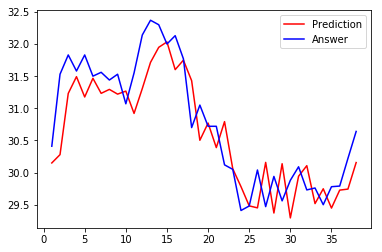

In [733]:
plt.plot(plot_1["pred"][1:39], color='red', label='Prediction')
plt.plot(plot_1["y_test"][1:39], color='blue', label='Answer')
plt.legend(loc='best')
plt.show()

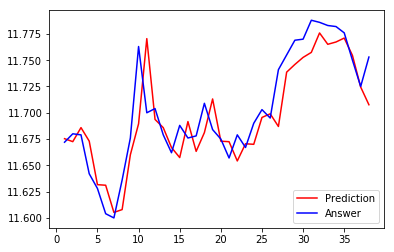

In [734]:
plt.plot(plot_2["pred"][1:39], color='red', label='Prediction')
plt.plot(plot_2["y_test"][1:39], color='blue', label='Answer')
plt.legend(loc='best')
plt.show()